# Ingest ERDDAP Data to output to Calvin (ODV)

- erddap has an odvText option but for the ALAMO's it seems to skip profiles on ingest
- clearly files without lat/lon get skipped but some others do as well.

Need to modify the header file:
```
//<Creator>https://ferret.pmel.noaa.gov/alamo/erddap/images/info.html</Creator>
//<CreateTime>2021-06-14T22:36:36</CreateTime>
//<Encoding>UTF-8</Encoding>
//<Software>ERDDAP - Version 2.11</Software>
//<Source>https://data.pmel.noaa.gov/alamo/erddap/tabledap/arctic_heat_alamo_profiles_11010.html</Source>
//<Version>ODV Spreadsheet V4.6</Version>
//<DataField>GeneralField</DataField>
//<DataType>Profiles</DataType>
//<MetaVariable>label="Cruise" value_type="INDEXED_TEXT" is_primary_variable="F" </MetaVariable>
//<MetaVariable>label="Station" value_type="INDEXED_TEXT" is_primary_variable="F" </MetaVariable>
//<MetaVariable>label="Type" value_type="TEXT:2" is_primary_variable="F" </MetaVariable>
//<MetaVariable>label="Longitude [degrees_east]" value_type="DOUBLE" is_primary_variable="F" comment="Longitude of the station, best estimate" </MetaVariable>
//<MetaVariable>label="Latitude [degrees_north]" value_type="DOUBLE" is_primary_variable="F" comment="Latitude of the station, best estimate" </MetaVariable>
//<MetaVariable>label="profileid" value_type="INDEXED_TEXT" is_primary_variable="F" </MetaVariable>
//<MetaVariable>label="yyyy-mm-ddThh:mm:ss.sss" value_type="DOUBLE" is_primary_variable="T" comment="Time" </MetaVariable>
//<DataVariable>label="FLOAT_SERIAL_NO" value_type="INDEXED_TEXT" is_primary_variable="F" comment="Unique  instrument identifier (e.g. instrument serial number)" </DataVariable>
//<DataVariable>label="CYCLE_NUMBER" value_type="INTEGER" is_primary_variable="F" comment="Instrument dive cycle number" </DataVariable>
//<DataVariable>label="PRES [decibar]" value_type="DOUBLE" is_primary_variable="F" comment="Sea water pressure, equals 0 at sea-level" </DataVariable>
//<DataVariable>label="TEMP [degree_Celsius]" value_type="DOUBLE" is_primary_variable="F" comment="Sea temperature in-situ ITS-90 scale" </DataVariable>
//<DataVariable>label="PSAL [PSU]" value_type="DOUBLE" is_primary_variable="F" comment="Practical salinity" </DataVariable>
Cruise	Station	Type	Longitude [degrees_east]	Latitude [degrees_north]	profileid	yyyy-mm-ddThh:mm:ss.sss	FLOAT_SERIAL_NO	CYCLE_NUMBER	PRES [decibar]	TEMP [degree_Celsius]	PSAL [PSU]
```

In [29]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

In [13]:
server_url='https://data.pmel.noaa.gov/alamo/erddap/'

e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='11010'))

In [14]:
dfm2 = {}
for dataset_id in sorted(df['Dataset ID'].values):
    print(f'{dataset_id}')

    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.dataset_id=dataset_id
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))
        continue
    try:
        dftemp = e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )
        dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]

        ##resample as daily data 
        dfm2.update({dataset_id: dftemp})
    except:
        pass

arctic_heat_alamo_profiles_11010


<AxesSubplot:xlabel='profileid'>

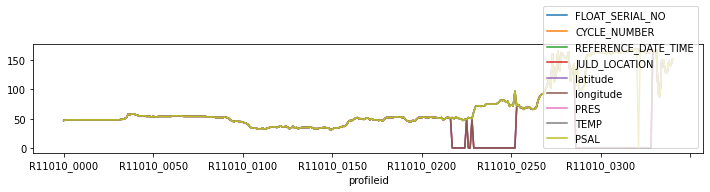

In [35]:
dfm2['arctic_heat_alamo_profiles_11010'].groupby('profileid').count().plot(figsize=(12,2))

In [54]:
dfm2['arctic_heat_alamo_profiles_11010'].dropna().groupby('profileid').count()

,FLOAT_SERIAL_NO,CYCLE_NUMBER,REFERENCE_DATE_TIME,JULD_LOCATION,latitude,longitude,PRES,TEMP,PSAL
profileid,,,,,,,,,
R11010_0000,47,47,47,47,47,47,47,47,47
R11010_0001,48,48,48,48,48,48,48,48,48
R11010_0002,48,48,48,48,48,48,48,48,48
R11010_0003,48,48,48,48,48,48,48,48,48
R11010_0004,48,48,48,48,48,48,48,48,48
...,...,...,...,...,...,...,...,...,...
R11010_0341,130,130,130,130,130,130,130,130,130
R11010_0342,128,128,128,128,128,128,128,128,128
R11010_0343,149,149,149,149,149,149,149,149,149


In [52]:
# dfm2['arctic_heat_alamo_profiles_11010']['profileid'].plot()
dfm2['arctic_heat_alamo_profiles_11010'].dropna().to_csv('arctic_heat_alamo_profiles_11010_pandas.csv')